In [1]:
!pip install featurewiz
import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from collections import Counter
from featurewiz import featurewiz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.datasets import make_regression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors, datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from xgboost import XGBRFClassifier
from xgboost import XGBClassifier

Imported 0.3.2 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False, skip_xgboost=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



In [2]:
np.random.seed(1234)

#load data
path = os.path.join(os.getcwd(), "sold_cleaned_11.21.23.csv")
data = pd.read_csv(path)

#inspect if data has any missing value
data.info()

#check data detailed info to see if any uncommon number
des=data.describe()


#drop unnecessary columns
data=data.drop(["property_url","mls","mls_id","status","street","unit","city","state","full_baths","half_baths","days_on_mls",\
                "list_price","list_date","last_sold_date","lot_sqft","latitude","longitude","stories","hoa_fee","parking_garage","metro_area"],axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304925 entries, 0 to 304924
Data columns (total 43 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   property_url                              304925 non-null  object 
 1   mls                                       283580 non-null  object 
 2   mls_id                                    283580 non-null  object 
 3   status                                    304925 non-null  object 
 4   style                                     304925 non-null  object 
 5   street                                    304871 non-null  object 
 6   unit                                      70926 non-null   object 
 7   city                                      304925 non-null  object 
 8   state                                     304925 non-null  object 
 9   zip_code                                  304925 non-null  int64  
 10  beds                

array([[<Axes: title={'center': 'beds'}>,
        <Axes: title={'center': 'sqft'}>,
        <Axes: title={'center': 'sold_price'}>,
        <Axes: title={'center': 'price_per_sqft'}>,
        <Axes: title={'center': 'Household Median Income'}>],
       [<Axes: title={'center': 'Total population'}>,
        <Axes: title={'center': 'age over 35 and less than 85'}>,
        <Axes: title={'center': 'age over 35 and less than 85 percentage '}>,
        <Axes: title={'center': 'Total housing units'}>,
        <Axes: title={'center': 'Occupied housing units/ Totla Household'}>],
       [<Axes: title={'center': 'Occupied housing units Percent (%)'}>,
        <Axes: title={'center': 'Owner-occupied'}>,
        <Axes: title={'center': 'Renter-occupied'}>,
        <Axes: title={'center': 'Vacant housing units'}>,
        <Axes: title={'center': 'Vacant housing units Percent (%)'}>],
       [<Axes: title={'center': 'Homeowner vacancy rate'}>,
        <Axes: title={'center': 'Rental vacancy rate'}>

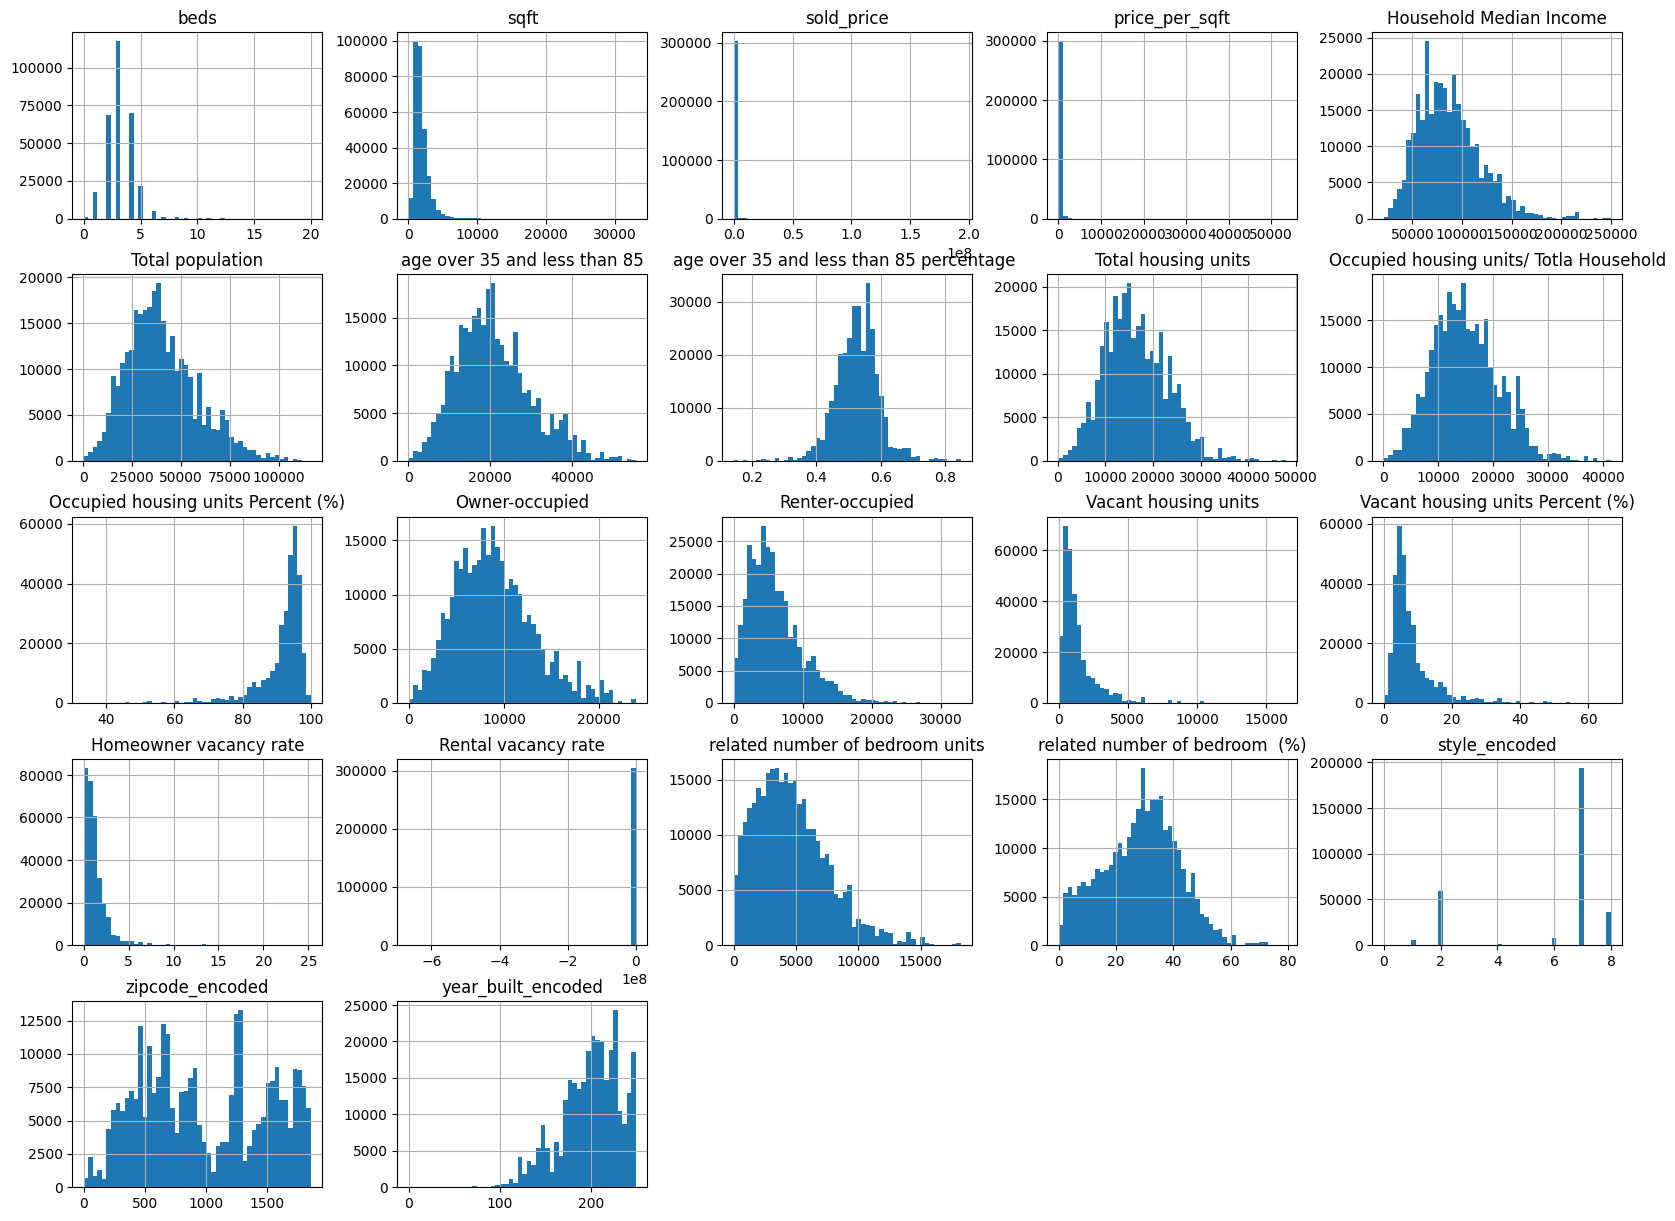

In [3]:
# make label for categorical features
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform style,zipcode, year_built columns to categorical data
data['style_encoded'] = label_encoder.fit_transform(data['style'].astype(str))
data['zipcode_encoded'] = label_encoder.fit_transform(data['zip_code'].astype(str))
data['year_built_encoded'] = label_encoder.fit_transform(data['year_built'].astype(str))

#drop style,zipcode, year_built columns
data=data.drop(["style","zip_code","year_built"],axis=1)

#plot historgram for all features
data.hist(bins=50,figsize=(20,15))

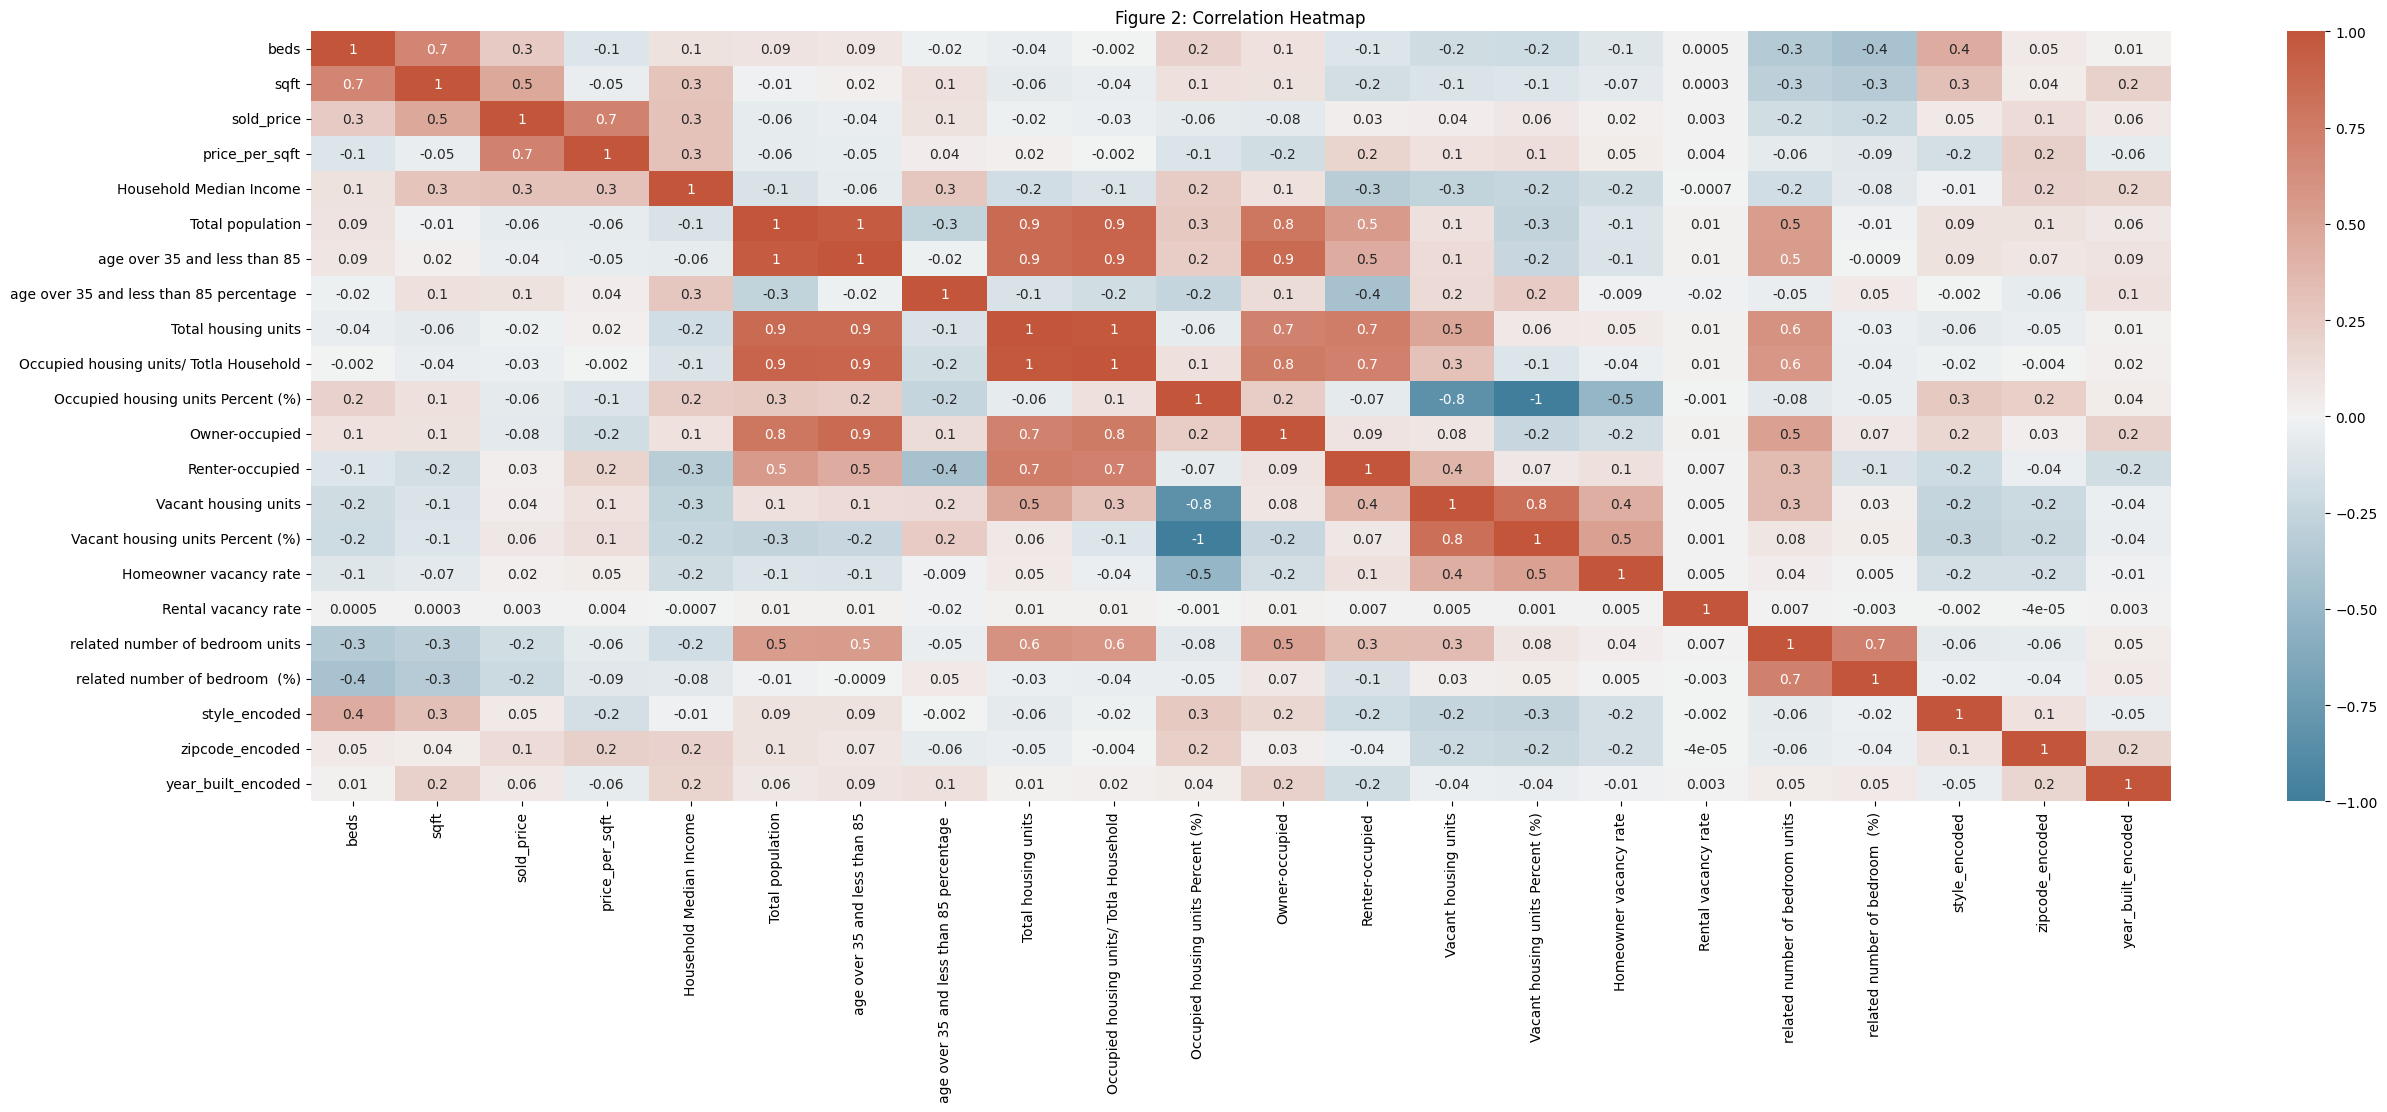

In [4]:
#check the correlation between each feature
corrDf = data.corr()
corrDf['sold_price'].sort_values(ascending=False)

#plot heatmap
cmap = sn.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(30,10))
sn.heatmap(corrDf, annot=True,fmt=".1g",vmin=-1,vmax=1,center=0,cmap=cmap)
plt.title("Figure 2: Correlation Heatmap",fontsize="large")

#extract the highly correlated pairs with absolute correlation over 0.05
corr_pairs = corrDf.unstack()
highly_corr_pairs=corr_pairs[(abs(corr_pairs)>=0.05)&(abs(corr_pairs)<1)].sort_values()

In [5]:
print(data.columns)

Index(['beds', 'sqft', 'sold_price', 'price_per_sqft',
       'Household Median Income', 'Total population',
       'age over 35 and less than 85',
       'age over 35 and less than 85 percentage ', 'Total housing units',
       'Occupied housing units/ Totla Household',
       'Occupied housing units Percent (%)', 'Owner-occupied',
       'Renter-occupied', 'Vacant housing units',
       'Vacant housing units Percent (%)', 'Homeowner vacancy rate',
       'Rental vacancy rate', 'related number of bedroom units',
       'related number of bedroom  (%)', 'style_encoded', 'zipcode_encoded',
       'year_built_encoded'],
      dtype='object')


In [6]:
#set X and y
feature_cols=['beds', 'sqft', 'price_per_sqft', 'Household Median Income', 'Total population',
'age over 35 and less than 85', 'age over 35 and less than 85 percentage ', 'Total housing units', 'Occupied housing units/ Totla Household', 'Occupied housing units Percent (%)',
'Owner-occupied', 'Renter-occupied', 'Vacant housing units', 'Vacant housing units Percent (%)', 'Homeowner vacancy rate', 'Rental vacancy rate', \
    'related number of bedroom units','related number of bedroom  (%)', 'style_encoded', 'zipcode_encoded', 'year_built_encoded']

X=data[feature_cols]
y=data['sold_price']

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (304925, 22)
    Some column names had special characters which were removed...
#### Single_Label Regression problem ####
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Regression problem ####
    loading a sequential sample of 10000 rows into pandas 

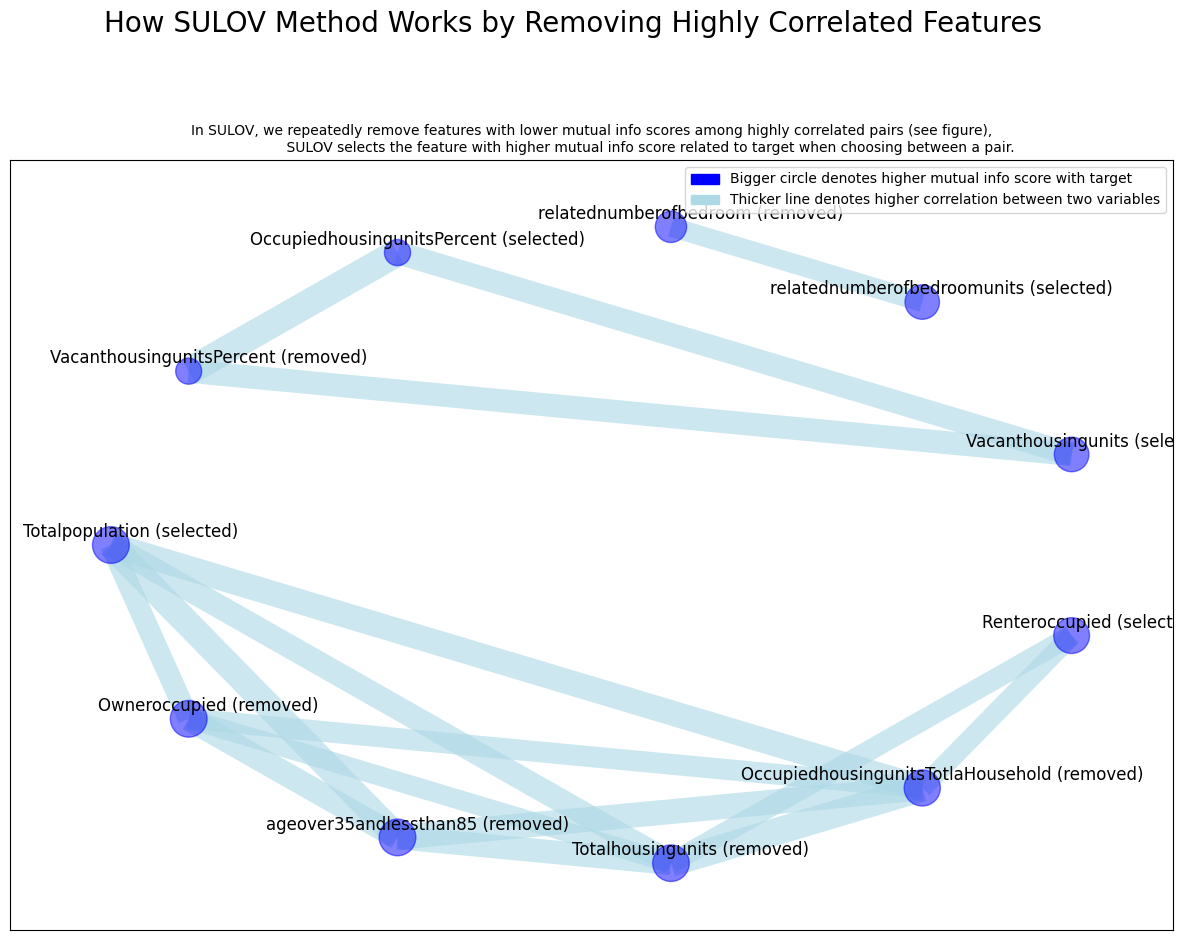

Time taken for SULOV method = 49 seconds
    Adding 0 categorical variables to reduced numeric variables  of 15
Final list of selected 15 vars after SULOV = ['beds', 'sqft', 'price_per_sqft', 'HouseholdMedianIncome', 'ageover35andlessthan85percentage', 'Homeownervacancyrate', 'Rentalvacancyrate', 'style_encoded', 'zipcode_encoded', 'year_built_encoded', 'Totalpopulation', 'Renteroccupied', 'Vacanthousingunits', 'relatednumberofbedroomunits', 'OccupiedhousingunitsPercent']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 5 features per iteration...
    XGBoost version using 1.7.6 as tree method: gpu_hist
    Number of booster rounds = 20
        Selected: ['price_per_sqft'

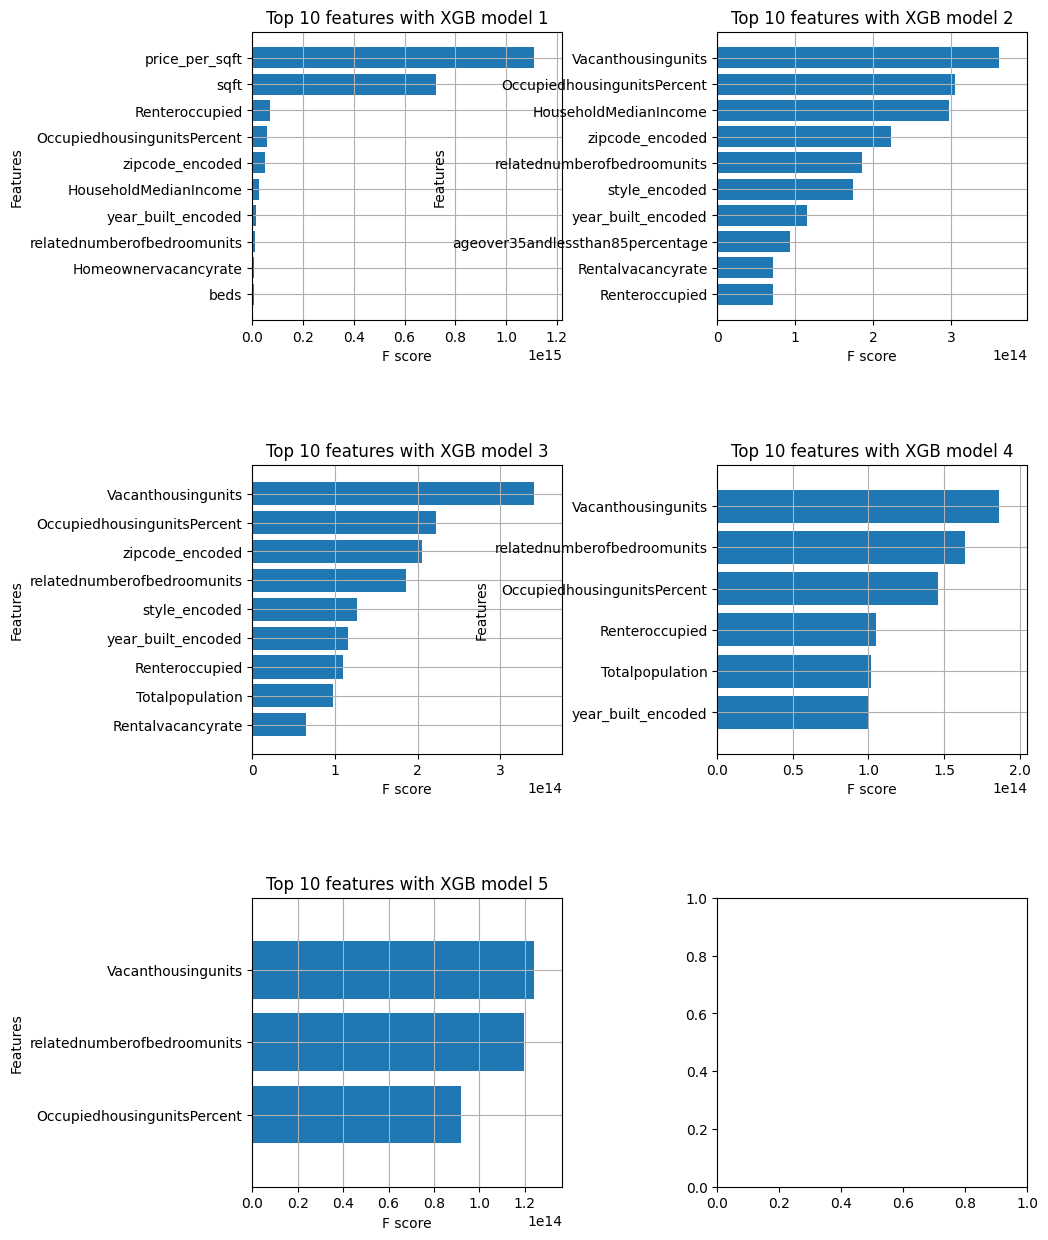

    Completed XGBoost feature selection in 4 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 10 important features:
['price_per_sqft', 'sqft', 'OccupiedhousingunitsPercent', 'HouseholdMedianIncome', 'zipcode_encoded', 'year_built_encoded', 'relatednumberofbedroomunits', 'Vacanthousingunits', 'Totalpopulation', 'Renteroccupied']
Total Time taken for featurewiz selection = 78 seconds
Output contains a list of 10 important features and a train dataframe


In [7]:
from featurewiz import featurewiz
# automatic feature selection by using featurewiz package
data_for_feature_selection=pd.concat([X,y],axis=1)
target = 'sold_price'

features, train = featurewiz(data_for_feature_selection, target, corr_limit=0.7, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")

#split data into feature and target
X_new = train[features]
y_new = train.sold_price.values.astype(int)


#split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, stratify=None, random_state=1)

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213447 entries, 283104 to 128037
Data columns (total 10 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   price_per_sqft                      213447 non-null  int64  
 1   sqft                                213447 non-null  int64  
 2   Occupied housing units Percent (%)  213447 non-null  float64
 3   Household Median Income             213447 non-null  int64  
 4   zipcode_encoded                     213447 non-null  int64  
 5   year_built_encoded                  213447 non-null  int64  
 6   related number of bedroom units     213447 non-null  int64  
 7   Vacant housing units                213447 non-null  int64  
 8   Total population                    213447 non-null  int64  
 9   Renter-occupied                     213447 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 17.9 MB


In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, mean_squared_log_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler

In [10]:
'''
# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=1)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Create a model with the best parameters
best_rf_model = grid_search.best_estimator_

# Fit the best model on the training data
best_rf_model.fit(X_train, y_train)
'''

'\n# Initialize the RandomForestRegressor\nrf_model = RandomForestRegressor(random_state=1)\n\n# Define a parameter grid for hyperparameter tuning\nparam_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'auto\', \'sqrt\'],\n    \'bootstrap\': [True, False]\n}\n\n# Create the grid search object\ngrid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring=\'neg_mean_squared_error\')\n\n# Fit the grid search to the data\ngrid_search.fit(X_train, y_train)\n\n# Get the best parameters\nbest_params = grid_search.best_params_\nprint(f"Best parameters: {best_params}")\n\n# Create a model with the best parameters\nbest_rf_model = grid_search.best_estimator_\n\n# Fit the best model on the training data\nbest_rf_model.fit(X_train, y_train)\n'

In [12]:
# Best parameters from your grid search
best_params = {
    'bootstrap': True,
    'max_depth': 20,
    'max_features': 'auto',
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 100
}

# Initialize RandomForestRegressor with the best parameters
best_rf_model = RandomForestRegressor(
    bootstrap=best_params['bootstrap'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators'],
    random_state=1  # Ensure reproducibility
)

# fit the best model with training data
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='auto', min_samples_leaf=2,
                      random_state=1)

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score

# Make predictions on the test data
predictions = best_rf_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
mad = median_absolute_error(y_test, predictions)

# MAPE - Mean Absolute Percentage Error
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

# EVS - Explained Variance Score
evs = explained_variance_score(y_test, predictions)

# R2 - Coefficient of Determination
r2 = r2_score(y_test, predictions)

# Calculate the standard deviation of the actual prices
std_actual_prices = np.std(y_test)

# Calculate Standardized Prediction Difference (SPD)
spd = (y_test - predictions) / std_actual_prices
mean_spd = np.mean(spd)

# Print the evaluation metrics
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAD: {mad}')
print(f'MAPE: {mape}')
print(f'EVS: {evs}')
print(f'R^2: {r2}')
print(f'Mean SPD: {mean_spd}')

# Extract and print feature importances
feature_importances = best_rf_model.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(feature_importances)[::-1]

print("Feature importances:")
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {feature_importances[idx]}")



MSE: 14676699854.03733
RMSE: 121147.43024116248
MAE: 3061.1524015916752
MAD: 609.4142760954564
MAPE: 0.22232832202449196
EVS: 0.9726330128367602
R^2: 0.9726329847820634
Mean SPD: 0.00016749536375228365
Feature importances:
price_per_sqft: 0.6286112365144326
sqft: 0.364960019342088
Renter-occupied: 0.0013983050012872547
Vacant housing units: 0.0012999436510446611
related number of bedroom units: 0.0011950744202738266
Household Median Income: 0.001149362982149142
zipcode_encoded: 0.0005764558548059078
Total population: 0.0004228002321903073
year_built_encoded: 0.00021186669324630152
Occupied housing units Percent (%): 0.00017493530848185416


In [14]:
#load data
path = os.path.join(os.getcwd(), "for_sale_cleaned_up_11.21.23_updated.xlsx")
for_sale = pd.read_excel(path)

In [15]:
# Fit and transform style,zipcode, year_built columns to categorical data
for_sale['zipcode_encoded'] = label_encoder.fit_transform(for_sale['zip_code'].astype(str))
for_sale['year_built_encoded'] = label_encoder.fit_transform(for_sale['year_built'].astype(str))

#drop style,zipcode, year_built columns
for_sale=for_sale.drop(["zip_code","year_built"],axis=1)


In [16]:
# Retrieve the feature names from the trained model
trained_model_feature_names = best_rf_model.feature_names_in_

# Reorder the columns in X_for_sale to match the order of the trained model's features
X_for_sale = for_sale[trained_model_feature_names]

In [18]:
import numpy as np

# Make predictions
predictions = best_rf_model.predict(X_for_sale)

# Round predictions to the nearest whole number
rounded_predictions = np.round(predictions, 0)

# Add rounded predictions to the dataframe
for_sale['predicted_value'] = rounded_predictions.astype(int)

# Save or display the results
for_sale.to_csv('Randomforest_prediction_final.csv', index=False)